In [91]:
import numpy as np
import pandas as pd

df = pd.read_csv("../data/total_data.csv")

In [92]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [93]:
df.rename(columns={"full_date": "date_time",
                  "pm": "value"}, inplace=True)

In [94]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [95]:
from functions import holt_winters_imputation_and_expand, plot_imputation_results

In [96]:
import sktime
from matplotlib import pyplot
import matplotlib as plt
import seaborn
import datetime
import pandas as pd
import statsmodels
import numpy as np

In [97]:
df.set_index("date_time", inplace=True)

df.index = pd.to_datetime(df.index)

# Generate the complete range of dates
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Reindex the DataFrame to include all dates
df = df.reindex(full_range)

# Set the index name back (optional)
df.index.name = 'date_time'

In [98]:
# df['value'] = holt_winters_imputation_and_expand(
#     df['value'],
#     seasonal_periods=365,
# )
# df.to_csv("../data/imputed_mean.csv")

In [99]:
df = pd.read_csv("../data/imputed_mean.csv")

In [100]:
df.set_index("date_time", inplace=True)

In [219]:
test_date = "2018-01-01" # 37-39 - 285
# test_date = "2018-04-01" # 50 - 375
# test_date = "2018-06-01" # 29 - 436
# test_date = "2019-01-01" # 35 - 650
# test_date = "2019-06-01"
# test_date = "2020-01-01"
# test_date = "2020-03-01"
df_train = df[df.index < test_date].copy()
df_test = df[df.index >= test_date].copy()

In [220]:
df_train.shape

(285, 1)

In [221]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

from sklearn.metrics import mean_squared_error

def evaluate_on_test(y_hat, y_true):
    return mape(y_true, y_hat), np.sqrt(mean_squared_error(y_hat, y_true))

def plot_preds(y_hat, y_true):
    predictions = pd.DataFrame({
        "Preds": y_hat,
        "Actual": y_true,
        # "train": t['value']
    })
    _, ax = pyplot.subplots()
    ax = predictions.plot(ax=ax)

## data prep

In [222]:
from statsforecast.models import SeasonalNaive
from statsforecast.core import StatsForecast
import pandas as pd

# Prepare your data
data = pd.DataFrame({'ds': df_train.index,
                     'y': df_train['value'].values})
data['unique_id'] = "mean"

data['ds'] = pd.to_datetime(data['ds'])

In [223]:
# Prepare your data
data_test = pd.DataFrame({'ds': df_test.index,
                     'y': df_test['value'].values})
data_test['unique_id'] = "mean"

data_test['ds'] = pd.to_datetime(data_test['ds'])

## ML models basics

In [224]:
def train_test_split(series, test_size=0.2):
    """
    Splits the series into train and test sets.

    Parameters:
        series (array-like): The transformed series to split.
        test_size (float): Proportion of the series to include in the test set (default: 0.2).
    
    Returns:
        tuple: (train_series, test_series)
    """
    try:
        n = len(series)
        test_count = int(n * test_size)
        train_series = series[:-test_count]
        test_series = series[-test_count:]
        return train_series, test_series
    except Exception as e:
        warnings.warn(f"Failed to split series into train and test sets: {e}")
        return series, None


In [225]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# data = preprocessor.remove_seasonality(data)
# data = data[~np.isnan(data)]
# result = seasonal_decompose(data, model='additive', period=300)
# result.plot()
# pyplot.show()

In [226]:
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from sklearn.linear_model import LinearRegression

from mlforecast.target_transforms import BaseTargetTransform
import numpy as np
from sklearn.preprocessing import FunctionTransformer

from mlforecast.target_transforms import GlobalSklearnTransformer
import pandas as pd
from mlforecast import MLForecast
from mlforecast.target_transforms import (BaseTargetTransform, Differences, AutoDifferences, AutoSeasonalDifferences, AutoSeasonalityAndDifferences,
           LocalStandardScaler, LocalMinMaxScaler, LocalRobustScaler, LocalBoxCox, GlobalSklearnTransformer)
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean

from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor 
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
from itertools import combinations, chain

from mlforecast.lag_transforms import ExpandingMean, RollingMean
from numba import njit

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet, BayesianRidge, HuberRegressor, SGDRegressor
from sklearn.svm import SVR 

@njit
def rolling_mean_48(x):
    return rolling_mean(x, window_size=48)

In [227]:
train_df = data.copy()
test_df = data_test.copy()

In [228]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plot_preds(y_pred, y_true):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Actual', marker='o', linestyle='-')
    plt.plot(y_pred, label='Forecast', marker='x', linestyle='--')
    plt.legend()
    plt.title('Forecast vs Actual')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.show()


In [229]:
target_transforms = [
    Differences([365]),  # some of them shoudln't be together
    AutoDifferences(380), 
    AutoSeasonalDifferences(season_length=365, max_diffs=380), 
    AutoSeasonalityAndDifferences(max_season_length=380, max_diffs=380),
    LocalStandardScaler(), 
    LocalMinMaxScaler(), 
    LocalBoxCox()
]

@njit
def rolling_mean_14(x):
    return rolling_mean(x, window_size=14)
@njit
def rolling_mean_30(x):
    return rolling_mean(x, window_size=30)

lag_transforms_options = [
    {1: [expanding_mean], 7: [expanding_mean, rolling_mean_14], 30: [rolling_mean_30]},
    {1: [expanding_mean], 7: [rolling_mean_14], 30: [expanding_mean]},
    {1: [rolling_mean_14], 7: [rolling_mean_30], 30: [expanding_mean]},
    {1: [rolling_mean_14], 30: [expanding_mean]},
    {1: [rolling_mean_14]},
    {},
]

In [230]:
forecast_configs = [
    {
        "model_name": "Lasso",
        "model": Lasso(),
        "target_transforms": [AutoDifferences(380)],
        "lag_transforms_options": {1: [rolling_mean_14], 30: [expanding_mean]},
        "lag_list": list(range(1, 41))
    },
    {
        "model_name": "Lasso",
        "model": Lasso(),
        "target_transforms": [AutoDifferences(380)],
        "lag_transforms_options": {1: [rolling_mean_14], 30: [expanding_mean]},
        "lag_list": (1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 25)
    },
    {
        "model_name": "Lasso",
        "model": Lasso(),
        "target_transforms": [AutoDifferences(380)],
        "lag_transforms_options": {1: [rolling_mean_14], 30: [expanding_mean]},
        "lag_list": (1, 3, 4, 5, 6, 7, 10, 12, 14, 15, 21, 22, 23, 25, 41)
    },
    # TODO: надо подбирать параметры в сгд. тк там рандом
    {
        "model_name": "SGDRegressor",
        "model": SGDRegressor(),
        "target_transforms": [LocalBoxCox()],
        "lag_transforms_options": {1: [rolling_mean_14], 30: [expanding_mean]},
        "lag_list": (1, 6, 11, 15, 173, 200, 335, 378, 379, 384)
    },
    {
        "model_name": "SGDRegressor",
        "model": SGDRegressor(),
        "target_transforms": [LocalBoxCox()],
        "lag_transforms_options": {1: [rolling_mean_14]},
        "lag_list": (1, 10, 11, 15, 16, 150, 172, 188, 198, 199, 222, 273, 336, 368, 384)
    },
    {
        "model_name": "SGDRegressor",
        "model": SGDRegressor(),
        "target_transforms": [AutoSeasonalityAndDifferences(max_season_length=380, max_diffs=380), LocalBoxCox()],
        "lag_transforms_options": {7: [rolling_mean_30], 1: [rolling_mean_14],  30: [expanding_mean]},
        "lag_list": (1, 7, 15, 18, 173, 200, 335, 368, 369, 379)
    },
    {
        "model_name": "ElasticNet",
        "model": ElasticNet(),
        "target_transforms": [AutoDifferences(380)],
        "lag_transforms_options": {1: [expanding_mean], 7: [rolling_mean_14], 30: [expanding_mean]}, 
        "lag_list": (1, 4, 7, 10, 14, 22, 173, 179, 182, 183, 184, 185, 187, 188, 193)
    },
]

In [231]:
train_df.shape

(285, 3)

Lasso MAPE: 931229.25% with transforms [<mlforecast.target_transforms.AutoDifferences object at 0x000001E50454D490>], lags [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40], and lag_transforms {1: [CPUDispatcher(<function rolling_mean_14 at 0x000001E57C5014E0>)], 30: [CPUDispatcher(<function expanding_mean at 0x000001E57AC8AAC0>)]}


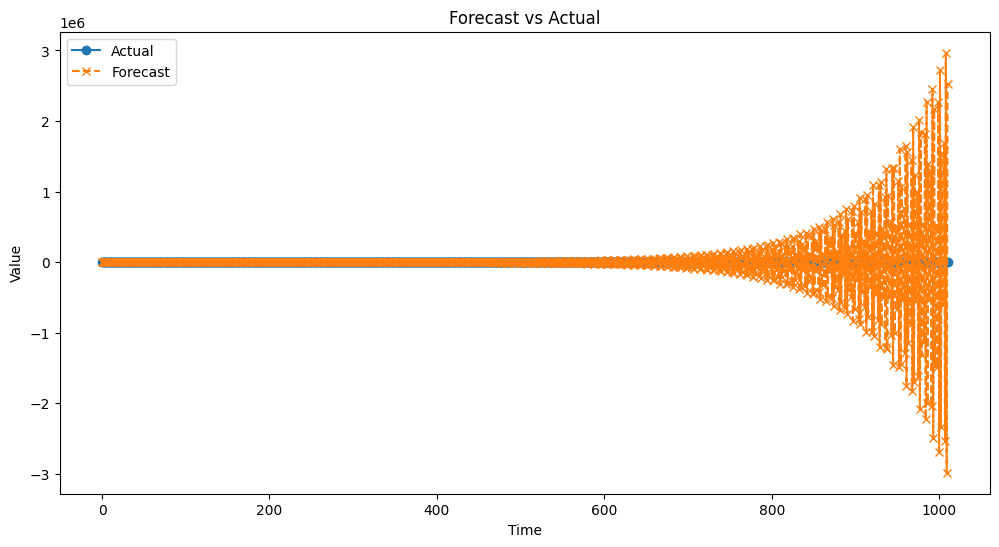

Lasso MAPE: 38.77% with transforms [<mlforecast.target_transforms.AutoDifferences object at 0x000001E57BF058E0>], lags (1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 25), and lag_transforms {1: [CPUDispatcher(<function rolling_mean_14 at 0x000001E57C5014E0>)], 30: [CPUDispatcher(<function expanding_mean at 0x000001E57AC8AAC0>)]}


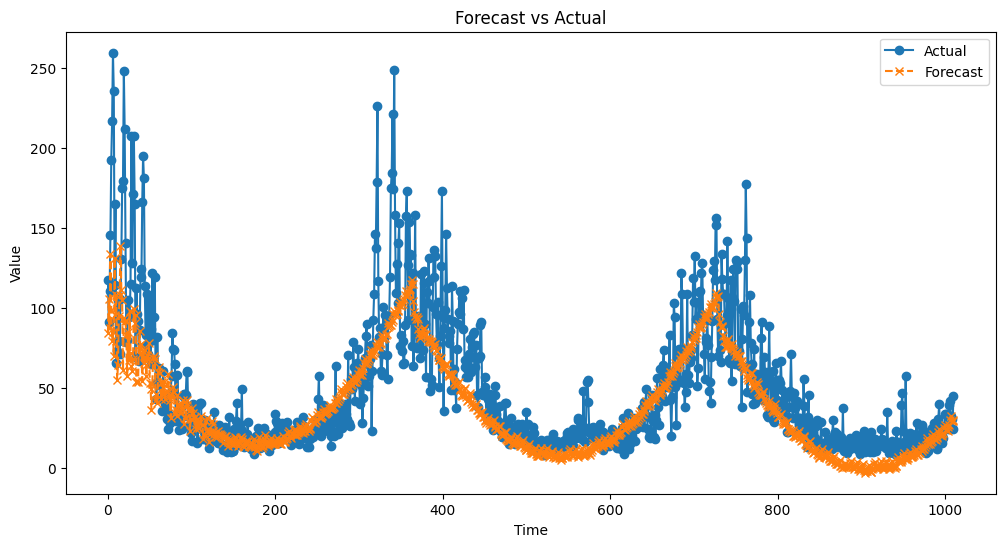

Lasso MAPE: 69.35% with transforms [<mlforecast.target_transforms.AutoDifferences object at 0x000001E57BF04B60>], lags (1, 3, 4, 5, 6, 7, 10, 12, 14, 15, 21, 22, 23, 25, 41), and lag_transforms {1: [CPUDispatcher(<function rolling_mean_14 at 0x000001E57C5014E0>)], 30: [CPUDispatcher(<function expanding_mean at 0x000001E57AC8AAC0>)]}


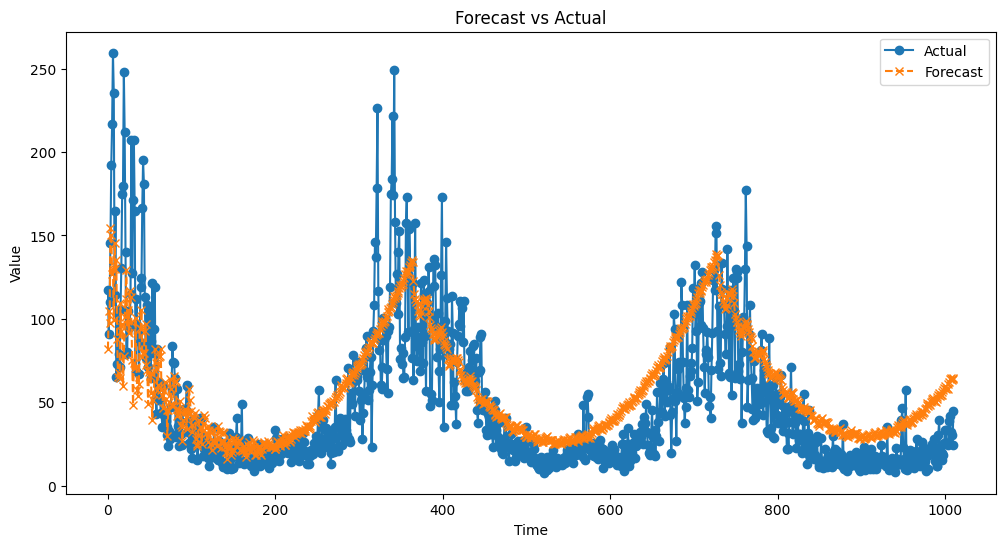

c:\Users\77019\pyver\py312\Lib\site-packages\mlforecast\core.py:434: UserWarning: The following series were dropped completely due to the transformations and features: ['mean'].
These series won't show up if you use `MLForecast.forecast_fitted_values()`.
You can set `dropna=False` or use transformations that require less samples to mitigate this
  warnings.warn(


ValueError: Found array with 0 sample(s) (shape=(0, 14)) while a minimum of 1 is required by SGDRegressor.

In [232]:
from mlforecast import MLForecast

results = {}

for config in forecast_configs:
    # Initialize MLForecast with the current configuration
    forecast = MLForecast(
        # models=[[config["models"].values()][0]],
        models=[config["model"]],
        freq="D",  # Modify as per your needs
        lags=config["lag_list"],
        lag_transforms=config["lag_transforms_options"],
        target_transforms=config["target_transforms"],
        date_features=['dayofweek', 'month'],
    )

    # Assume `train_data` is your input DataFrame
    forecast.fit(train_df)

    # Store trained model instance
    results[config["model_name"]] = forecast

    predictions = forecast.predict(h=len(test_df['y']))

    test_df['forecast'] = predictions[config["model_name"]]
    error = mape(test_df['y'].values, test_df['forecast'].values)

    print(f"{config["model_name"]} MAPE: {error:.2f}% with transforms {config["target_transforms"]}, lags {config["lag_list"]}, and lag_transforms {config["lag_transforms_options"]}")
    
    plot_preds(test_df['forecast'].values, test_df['y'].values)